<a href="https://colab.research.google.com/github/huggingface/huggingface_sb3/blob/main/notebooks/Stable_Baselines_3_x_Hugging_Face_%F0%9F%A4%97_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Baselines 3 x Hugging Face 🤗 tutorial
Stable-Baselines3 (SB3): https://github.com/DLR-RM/stable-baselines3

Stable-Baselines3 Documentation: https://stable-baselines.readthedocs.io/en/master/

Hugging Face SB3 documentation: https://huggingface.co/docs/hub/stable-baselines3#using-stablebaselines3-at-hugging-face



## Introduction
In this notebook, you're going to learn:
1. How to train a Deep Reinforcement Learning lander agent to land correctly on the Moon 🌕 using `stable-baselines3`and how upload it to the Hub 🚀.

In [ ]:
%%html
<video controls autoplay><source src="https://huggingface.co/ThomasSimonini/ppo-LunarLander-v2/resolve/main/replay.mp4" type="video/mp4"></video>

2. How to download and use a saved model from the Hub that plays Space Invaders 👾.

In [ ]:
%%html
<video controls autoplay><source src="https://huggingface.co/ThomasSimonini/ppo-SpaceInvadersNoFrameskip-v4/resolve/main/output.mp4" type="video/mp4"></video>

💡 We advise you to use Google Colab since some environments work only with Ubuntu. The free version of Google Colab is perfect for this tutorial.
Let's get started 🚀

### Set the GPU 💪
- To **accelerate the agent's training, we'll use a GPU**. To do that, go to `Runtime > Change Runtime type`

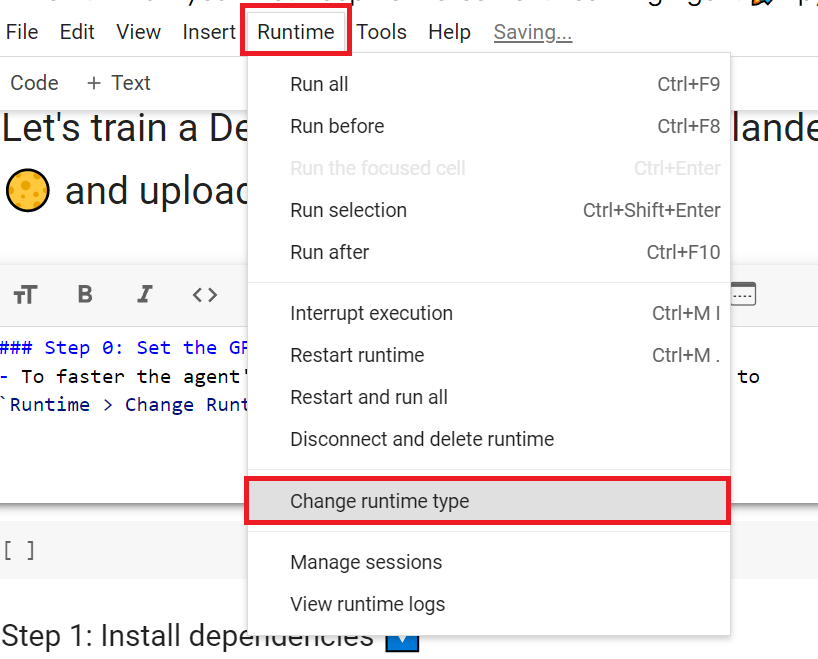


- `Hardware Accelerator > GPU`

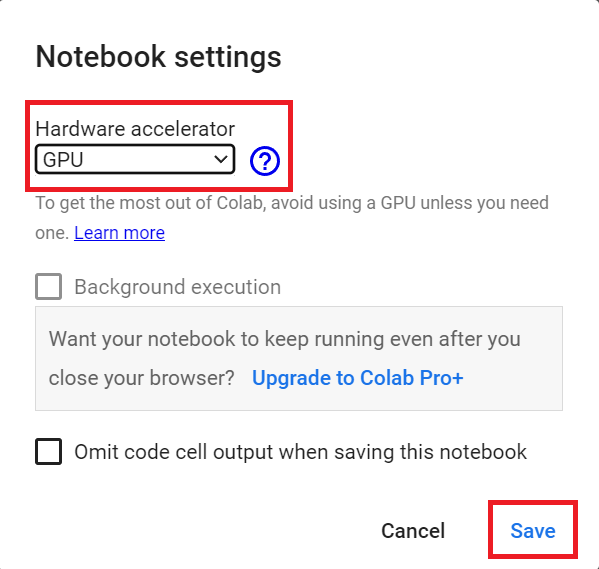

### Set a virtual screen 💻

During the notebook, we'll need to generate a replay video. To do so, with colab, **we need to have a virtual screen to be able to render the environment** (and thus record the frames). 

Hence the following cell will install virtual screen libraries and create and run a virtual screen 🖥

If you have this error `FileNotFoundError: [Errno 2] No such file or directory: 'Xvfb': 'Xvfb'` please restart the colab.

In [ ]:
!sudo apt-get update
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

### Install dependencies 🔽
The first step is to install the dependencies, we’ll install multiple ones:

- `gym[box2D]`: Contains the LunarLander-v2 environment 🌛
- `gym[Atari]`: Contains the SpaceInvadersNoFrameSkip-v4 environment 👾.
- `stable-baselines3[extra]`: The deep reinforcement learning library.
- `huggingface_sb3`: Additional code for Stable-baselines3 to load and upload models from the Hugging Face 🤗 Hub.

In [ ]:
!pip install importlib-metadata==4.12.0 # To overcome an issue with importlib-metadata https://stackoverflow.com/questions/73929564/entrypoints-object-has-no-attribute-get-digital-ocean
!pip install gym[box2d]
!pip install gym[Atari]
!pip install stable-baselines3[extra]
!pip install huggingface_sb3
!pip install pyglet
!pip install ale-py==0.7.4 # To overcome an issue with gym (https://github.com/DLR-RM/stable-baselines3/issues/875)

!pip install pickle5

We also install colabgymrender package by [Ryan Rudes](https://github.com/ryanrudes). A library that records our agent performing in the environment and outputs a video.

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2
!pip install imageio==2.4.1

### Import the packages 📦

In [ ]:
import gym

from huggingface_sb3 import load_from_hub, package_to_hub, push_to_hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env

## Case 1: Train a Deep Reinforcement Learning lander agent to land correctly on the Moon 🌕 and upload it to the Hub.

### Create the LunarLander environment 🌛
#### The environment 🎮
In this first tutorial, we’re going to train our agent, a Lunar Lander, **to land correctly on the moon**. To do that, he needs to learn **to adapt its speed and position(horizontal, vertical, and angular) to land correctly.**



In [ ]:
%%html
<video controls autoplay><source src="https://huggingface.co/ThomasSimonini/ppo-LunarLander-v2/resolve/main/replay.mp4" type="video/mp4"></video>

The state is a vector 👁:
- Horizontal pad coordinate (x)
- Vertical pad coordinate (y)
- Horizontal speed (x)
- Vertical speed (y)
- Angle
- Angular speed
- If the left leg has contact point touched the land
- If the right leg has contact point touched the land


The action space is discrete with 4 actions available 🎮: 

- Do nothing,
- Fire left orientation engine,
- Fire the main engine,
- Fire right orientation engine.

Reward function 💰:

- Moving from the top of the screen to the landing pad and zero speed is about 100~140 points.
- Firing main engine is -0.3 each frame
- Each leg ground contact is +10 points
- Episode finishes if the lander crashes (additional - 100 points) or come to rest (+100 points)
- The game is solved if your agent does 200 points.


#### Vectorized Environment
- We create a vectorized environment (method for stacking multiple independent environments into a single environment) of 16 environments, this way, **we'll have more diverse experiences during the training.**

In [ ]:
# Create the environment
env = make_vec_env('LunarLander-v2', n_envs=16)

### Create the PPO Model 🤖
PPO is one of the SOTA (state of the art) Deep Reinforcement Learning algorithms. If you don't know how it works, you can check this [blogpost](https://towardsdatascience.com/proximal-policy-optimization-ppo-with-sonic-the-hedgehog-2-and-3-c9c21dbed5e) and the [paper](https://arxiv.org/pdf/1707.06347.pdf)

In this case, because we have a vector as input, we'll use an MLP (multi-layer perceptron) as policy.



In [ ]:
# Define a PPO MLpPolicy architecture
model = PPO(
    policy = 'MlpPolicy',
    env = env,
    n_steps = 1024,
    batch_size = 64,
    n_epochs = 4,
    gamma = 0.999,
    gae_lambda = 0.98,
    ent_coef = 0.01,
    verbose=1)

### Train the PPO agent 🏃
- Let's train our agent for 1,000,000 timesteps, don't forget to use GPU on Colab. It will take approximately ~25min

In [ ]:
# Train it for 1000000 timesteps
model.learn(total_timesteps=1000000)

# Save the model 
model.save("ppo-LunarLander-v2")

### Evaluate the agent 📈
- Now that's our lunar lander agent is trained, we need to **check its performance**.
- Stable-Baselines3 provides a method to do that `evaluate_policy`


In [ ]:
# Evaluate the agent
eval_env = gym.make('LunarLander-v2')
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

- In my case, the mean reward is `260.16 +/- 18.14` which means that my lunar lander agent is ready to land on the moon 🌛🥳.

### Publish our trained model on the Hub 🔥
Now that we saw we got good results after the training, we can publish our trained model on the hub 🤗 with one line of code.

📚 The libraries documentation 👉 https://github.com/huggingface/huggingface_sb3/tree/main#hugging-face--x-stable-baselines3-v20

Here's an example of a Model Card:

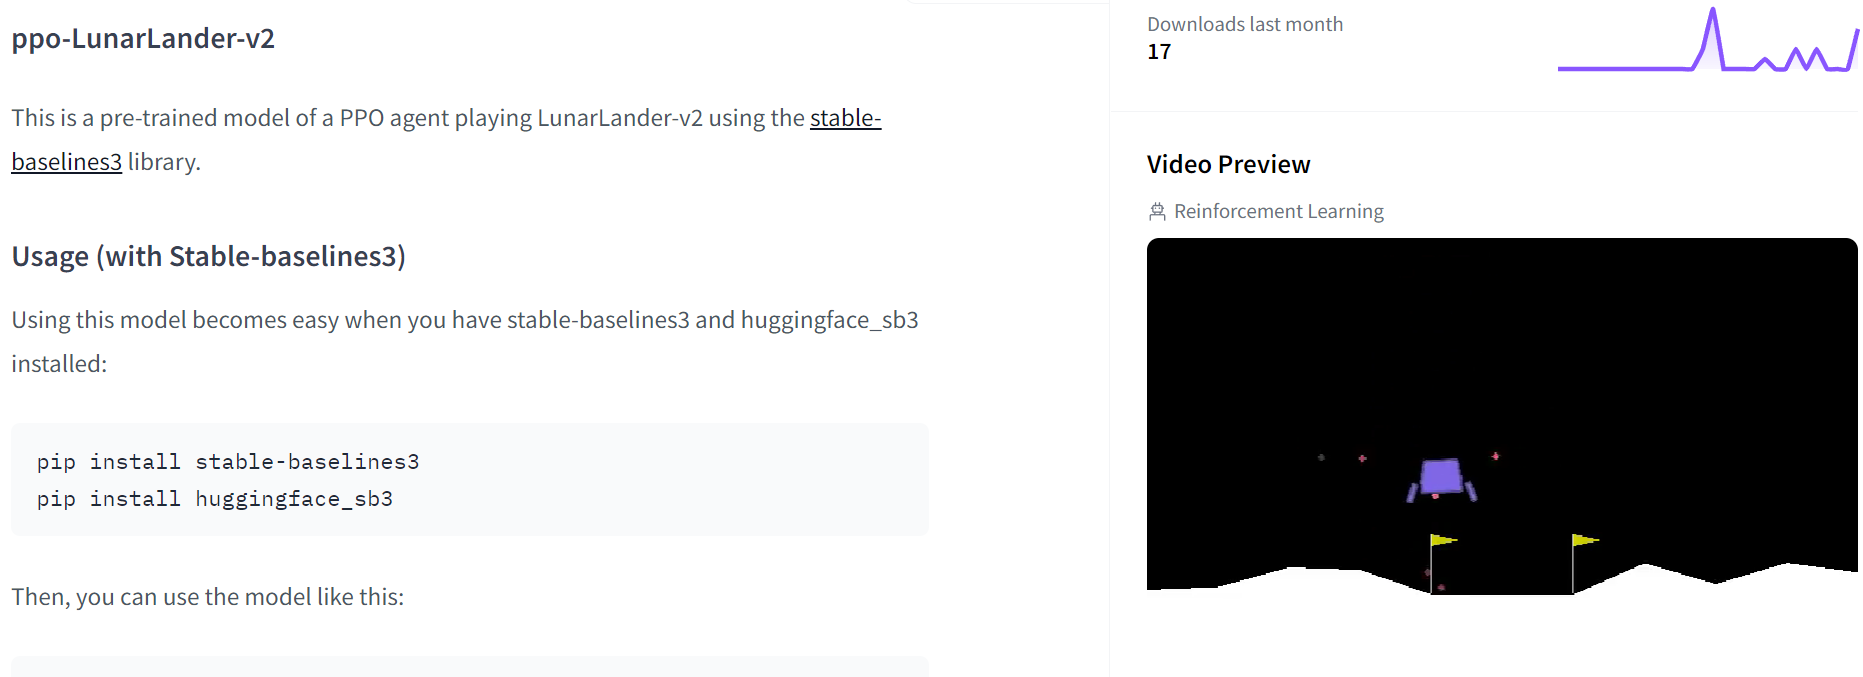

By using `package_to_hub` **you evaluate, record a replay, generate a model card of your agent and push it to the hub**.

---
The package_to_hub function
---

This way:
- You can **showcase our work** 🔥
- You can **visualize your agent playing** 👀
- You can **share with the community an agent that others can use** 💾
- You can **access a leaderboard 🏆 to see how well your agent is performing compared to your classmates** 👉 https://huggingface.co/spaces/huggingface-projects/Deep-Reinforcement-Learning-Leaderboard


To be able to share your model with the community there are three more steps to follow:

1️⃣ (If it's not already done) create an account to HF ➡ https://huggingface.co/join

2️⃣ Sign in and then, you need to store your authentication token from the Hugging Face website.
- Create a new token (https://huggingface.co/settings/tokens) **with write role**

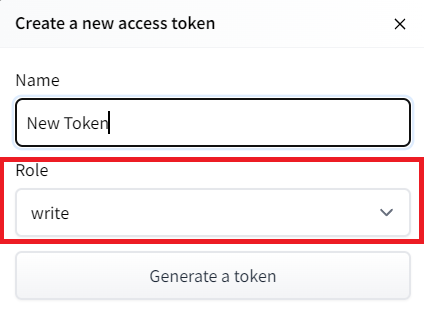

- Copy the token 
- Run the cell below and paste the token

In [ ]:
notebook_login()
!git config --global credential.helper store

If you don't want to use a Google Colab or a Jupyter Notebook, you need to use this command instead: `huggingface-cli login`

3️⃣ We're now ready to push our trained agent to the 🤗 Hub 🔥 using `package_to_hub()` function

Let's fill the `package_to_hub` function:
- `model`: our trained model.
- `model_name`: the name of the trained model that we defined in `model_save`
- `model_architecture`: the model architecture we used: in our case PPO
- `env_id`: the name of the environment, in our case `LunarLander-v2`
- `eval_env`: the evaluation environment defined in eval_env
- `repo_id`: the name of the Hugging Face Hub Repository that will be created/updated `(repo_id = {username}/{repo_name})`

💡 **A good name is {username}/{model_architecture}-{env_id}**

- `commit_message`: message of the commit

In [ ]:
import gym
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

from huggingface_sb3 import package_to_hub

# method save, evaluate, generate a model card and record a replay video of your agent before pushing the repo to the hub
package_to_hub(model=model, # Our trained model
               model_name="ppo-LunarLander-v2", # The name of our trained model 
               model_architecture="PPO", # The model architecture we used: in our case PPO
               env_id="LunarLander-v2", # Name of the environment
               eval_env=eval_env, # Evaluation Environment
               repo_id="ThomasSimonini/ppo-LunarLander-v2", # id of the model repository from the Hugging Face Hub (repo_id = {organization}/{repo_name} for instance ThomasSimonini/ppo-LunarLander-v2
               commit_message="Push to Hub")

# Note: if after running the package_to_hub function and it gives an issue of rebasing, please run the following code
# cd <path_to_repo> && git add . && git commit -m "Add message" && git pull 
# And don't forget to do a "git push" at the end to push the change to the hub.

Congrats 🥳 you've just trained and uploaded your first Deep Reinforcement Learning agent. The script above should have displayed a link to a model repository. When you go to this link, you can:
* see a video preview of your agent at the right. 
* click "Files and versions" to see all the files in the repository.
* click "Use in stable-baselines3" to get a code snippet that shows how to load the model.
* a model card (`README.md` file) which gives a description of the model

Under the hood, the Hub uses git-based repositories (don't worry if you don't know what git is), which means you can update the model with new versions as you experiment and improve your agent.

If you want, you can compare the results of your LunarLander-v2 with other users using the leaderboard 🏆 👉 https://huggingface.co/spaces/huggingface-projects/Deep-Reinforcement-Learning-Leaderboard

## Case 2: Download a saved model from the hub that plays Space Invaders 👾
Most of the time, training an agent can be very long (for instance 2 days and more!). To avoid that, you can directly download trained agents on the 🤗 Hub and test them.

Here, we're going to download a trained agent that learned to play Space Invaders 👾

### Load the saved model from the hub 🤗
Loading a saved model from the Hub is really easy. 

1. You go https://huggingface.co/models?library=stable-baselines3 to see the list of all the Stable-baselines3 saved models.
2. You select one and copy its repo_id
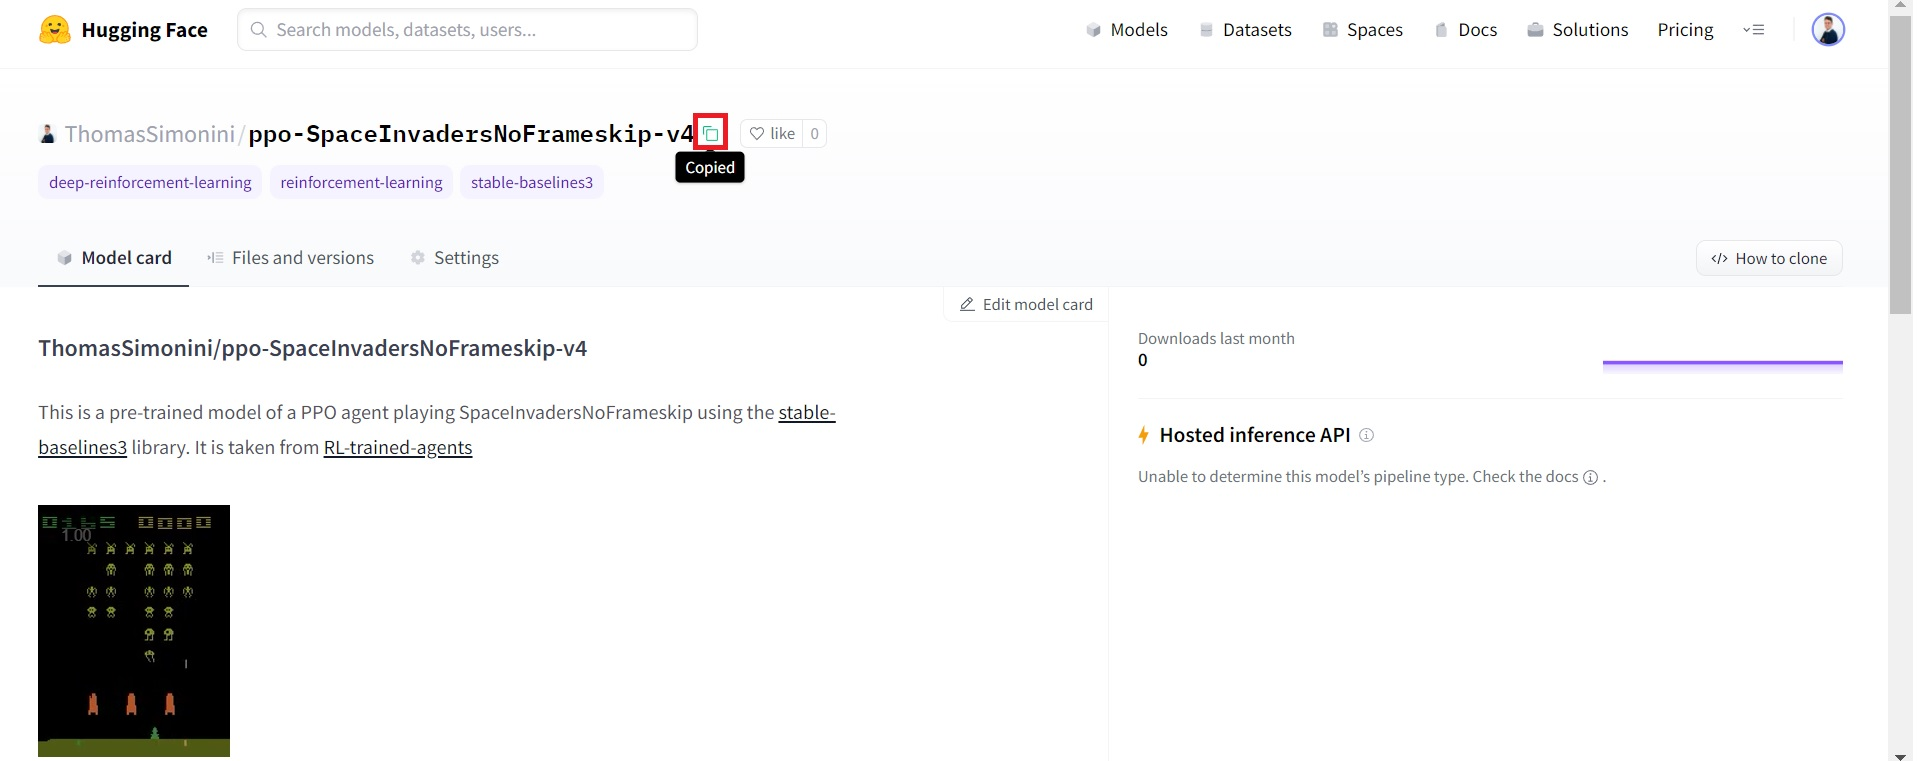


3. Then we just need to use load_from_hub with:
- The repo_id
- The filename: the saved model inside the repo and its extension (*.zip)

In [ ]:
from huggingface_sb3 import load_from_hub
repo_id = "sb3/ppo-SpaceInvadersNoFrameskip-v4" # The repo_id
filename = "ppo-SpaceInvadersNoFrameskip-v4.zip" # The model filename.zip

# When the model was trained on Python 3.8 the pickle protocol is 5
# But Python 3.6, 3.7 use protocol 4
# In order to get compatibility we need to:
# 1. Install pickle5 (we done it at the beginning of the colab)
# 2. Create a custom empty object we pass as parameter to PPO.load()
custom_objects = {
            "learning_rate": 0.0,
            "lr_schedule": lambda _: 0.0,
            "clip_range": lambda _: 0.0,
}

checkpoint = load_from_hub(repo_id, filename)
model = PPO.load(checkpoint, custom_objects=custom_objects, print_system_info=True)

### Let's watch our agent performing 🎥 (Google Colab only)
- We're going to use colabgymrender package by [Ryan Rudes](https://github.com/ryanrudes) that records our agent performing in the environment and outputs a video.

- If you're not using Google Colab, you can check [Stable-baselines3 documentation](https://stable-baselines3.readthedocs.io/en/master/guide/examples.html?highlight=video#record-a-video) to find how to record a video.

In [ ]:
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from colabgymrender.recorder import Recorder

env = make_atari_env('SpaceInvadersNoFrameskip-v4', n_envs=1, seed=0)
env = VecFrameStack(env, n_stack=4)

directory = './video'
env = Recorder(env, directory)

obs = env.reset()
done = False
while not done:
  action, _state = model.predict(obs)
  obs, reward, done, info = env.step(action)
env.play()



That's all for today!

We're excited to see what you're working on with Stable-baselines3 and try your models in the Hub 😍.

And we would love to hear your feedback 💖. 📧 Feel free to [reach us](mailto:thomas.simonini@huggingface.co)  

Finally, we would like to thank the SB3 team and in particular [Antonin Raffin](https://araffin.github.io/) for their precious help for the integration of the library 🤗.

📢 And if you would like to **join our community of creators, we would love to meet you in our Discord server** 🤗.
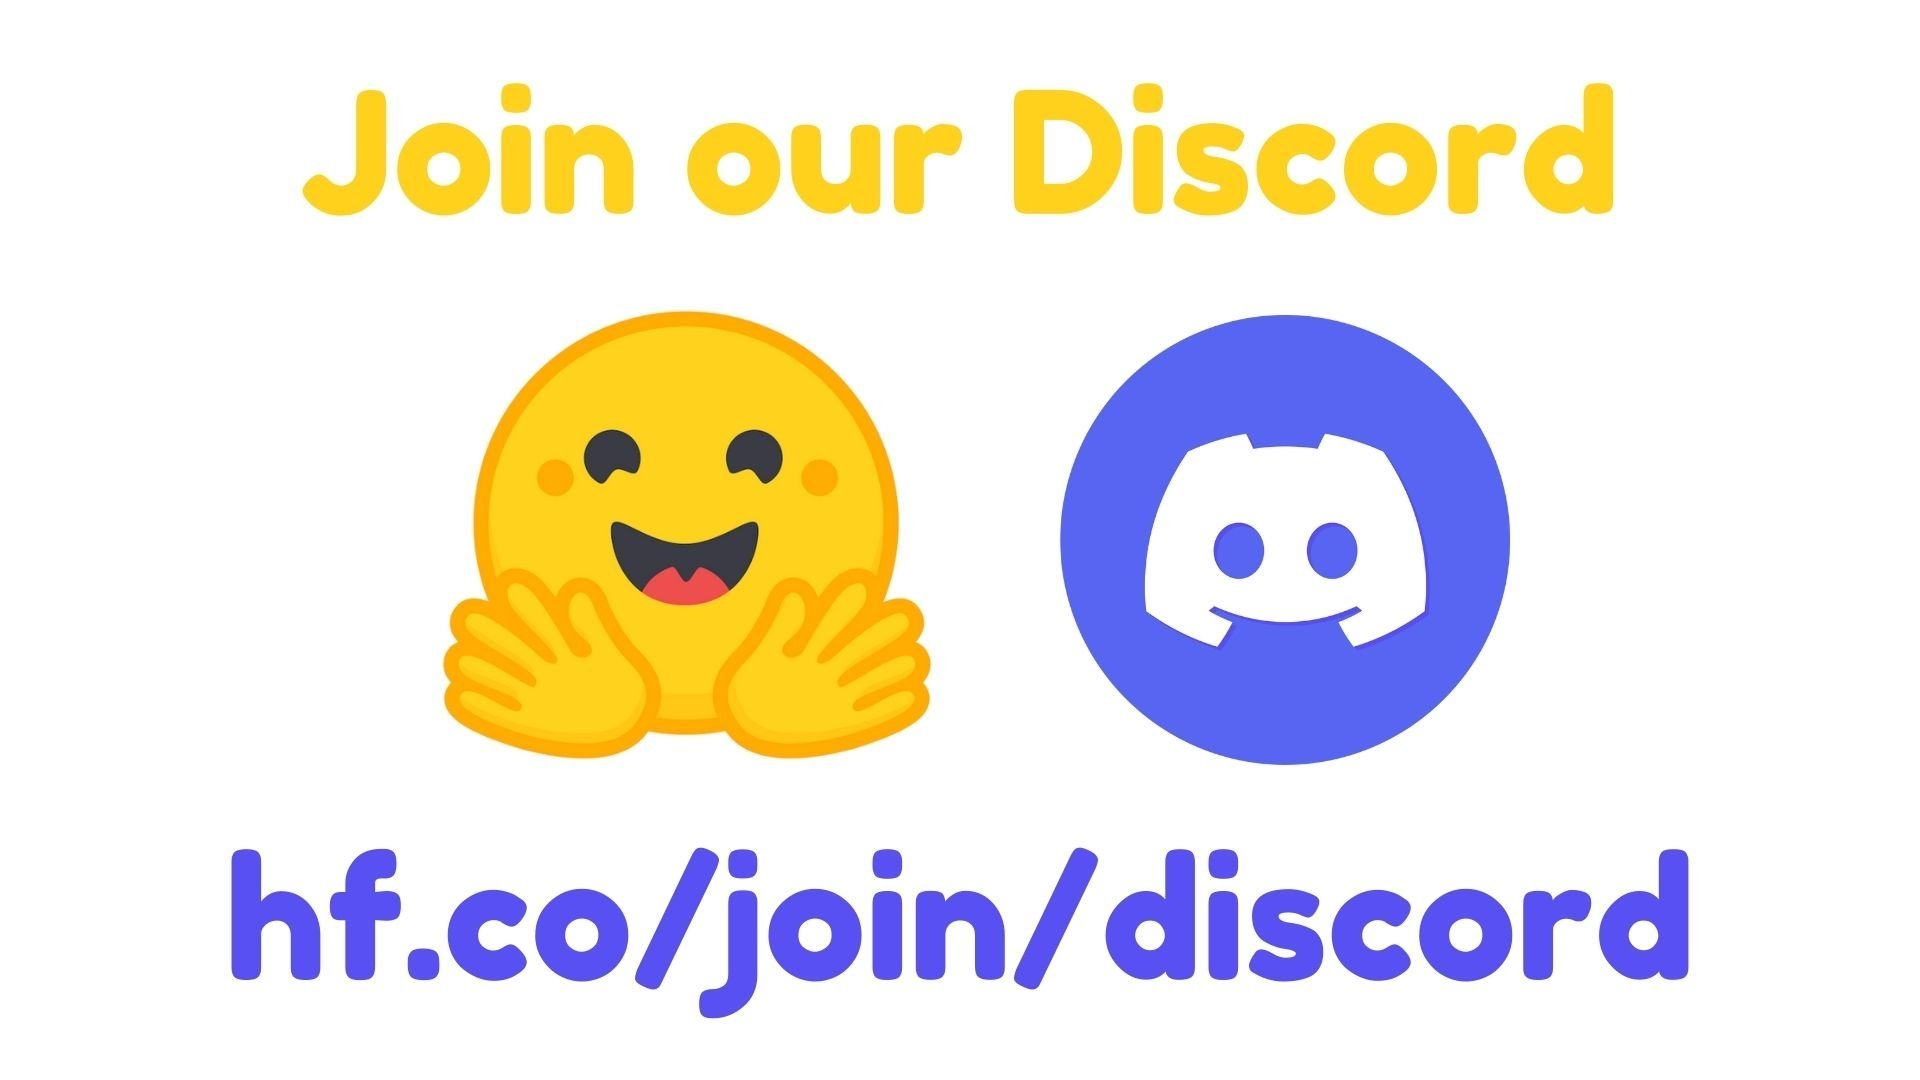
👉 https://discord.gg/Y5HUB4Wrm7